In [1]:
import hera_stats as hs
import hera_pspec as hp
import matplotlib.pyplot as plt
import numpy as np
import os
from hera_stats.data import DATA_PATH

/users/drocha/Python/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Settings:

# Import settings
container_path = os.path.join(DATA_PATH, "uvp_data.h5")
pc_group = "IDR2_1"
pc_psnames = None

# Analysis settings
n_bins = 20
pol = "xx"

# Output settings
pc_out = hp.container.PSpecContainer("./jk_data.h5", "rw")

# PSpec settings
sample_baseline = (0, 1)
bl_tol = 0.1

In [3]:
# Open container
pc = hp.container.PSpecContainer(container_path)

# Get pspecs from list or string
if isinstance(pc_psnames, (tuple, list, np.ndarray)):
    uvp_list = [pc.get_pspec(group=pc_group, psname=ps) for ps in pc_psnames]
else:
    uvp_list = pc.get_pspec(group=pc_group, psname=pc_psnames)

In [4]:
# Redundant baseline calculation, given the sample baseline in cell 2.
uvp = hp.uvpspec.combine_uvpspec(uvp_list)

# Get position and baseline information
pos = uvp.get_ENU_bl_vecs()
all_bls = [uvp.bl_to_antnums(b) for b in uvp.bl_array]
dic = dict(zip(all_bls, pos))

# Find baselines that match the sample_baseline vector very closely
bls = []
for b in all_bls:
    if sum((dic[sample_baseline] - dic[b])**2) < bl_tol:
        bls.append(b)
    else:
        print b

uvp 0 and 1 are concatable across blpairts axis


In [5]:
sp_g = hs.jackknives.split_gha(uvp, [n_bins], bls=bls)

In [6]:
sp_g = hs.jackknives.bootstrap_jackknife(sp_g, pol=pol)

In [7]:
hs.jackknives.save_jackknife(pc_out, sp_g, overwrite=True)
pc_out.save()

In [8]:
jk = hs.JKSet(sp_g, jktype="spl_gha")
zs = hs.stats.zscores(jk[0])
jk

<hera_stats.jkset.JKSet instance at 0x7f7a519f6bd0>

Jackknife Data
--------------
jktype: spl_gha
data shape: (1, 20)

In [9]:
def weightedsum(specs, errs, axis=1):
    # Do weighted sum calculation
    aerrs = 1. / np.sum(errs ** -2, axis=axis)
    av = aerrs * np.sum(specs * errs**-2, axis=axis)
    std = (aerrs * len(specs)) ** 0.5
    
    return av, std

In [10]:
# Split delay spectrum into 4 equal parts, the outer 2 go to the "wings" array
# and the center 2 go to the "center" array
q1 = len(jk.dlys) // 4
q2 = len(jk.dlys) - q1
wings_i = np.arange(-q1, q1) % 100
center_i = np.arange(q1, q2)

wings = jk[0].spectra[:, wings_i]
wings_e = jk[0].errs[:, wings_i]
center = jk[0].spectra[:, center_i]
center_e = jk[0].errs[:, center_i]

In [11]:
# Weighted sum over the wings and center to get average over GHA
wing_av, wing_std = weightedsum(wings, wings_e)
cent_av, cent_std = weightedsum(center, center_e)

In [12]:
# x-axis will be galactic hourangle
angs = jk[0].grps.flatten().astype(float)

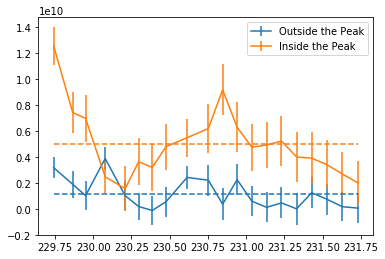

In [13]:
# Plot both as lines with error, to see if the wings are behavng wildly at any point.
# (this could mean GHA-dependent signal.)
e1 = plt.errorbar(angs, wing_av, wing_std)
e2 = plt.errorbar(angs, cent_av, cent_std)
plt.hlines(np.average(wing_av), min(angs), max(angs), color="C0", linestyles="--")
plt.hlines(np.average(cent_av), min(angs), max(angs), color="C1", linestyles="--")

plt.legend([e1, e2], ["Outside the Peak", "Inside the Peak"])